In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from collections import defaultdict

In [44]:
from IPython import display
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
%matplotlib inline

EpisodeStats = namedtuple('Stats', ['episode_lengths', 'episode_rewards'])


def plot_value_function(V, title = "Value Function"):
    '''
    Plots the value function as a surface plot.
    '''
    min_x = 11 # min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize = (20, 10))
        ax = fig.add_subplot(111, projection = '3d')
        surf = ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1,
                               cmap = matplotlib.cm.coolwarm, vmin = -1.0, vmax = 1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

env = gym.make('Blackjack-v1') # insert your favorite environment
env.reset()
img = plt.show(env.render())

for _ in range(100):
    display.display(plt.gcf())
    display.clear_output(wait = True)
    action = env.action_space.sample()
    env.step(action)

<Figure size 640x480 with 0 Axes>

In [34]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    """
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [35]:
def mc_prediction(policy, env, num_episodes, discount_factor = 1.0):

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    
    for i_episode in range(num_episodes):
        observation = env.reset()[0]
        
        episodes = []
        for i in range(100):
            action = policy(observation)
            next_observation, reward, done,_ , x= env.step(action)
            episodes.append((observation, action, reward))
            if done:
                break
            observation = next_observation
        
        # obtain unique observation set
        observations = set([x[0] for x in episodes])
        for i, observation in enumerate(observations):
            # first occurence of the observation
            idx = episodes.index([episode for episode in episodes if episode[0] == observation][0])
            
            Q = sum([episode[2] * discount_factor ** i for episode in episodes[idx:]])
            
            returns_sum[observation] += Q
            returns_count[observation] += 1.0
            
            V[observation] = returns_sum[observation] / returns_count[observation]
                
    return V

In [36]:
env = gym.make('Blackjack-v1')

# A policy that sticks if the player score is >= 20 and hits otherwise.
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

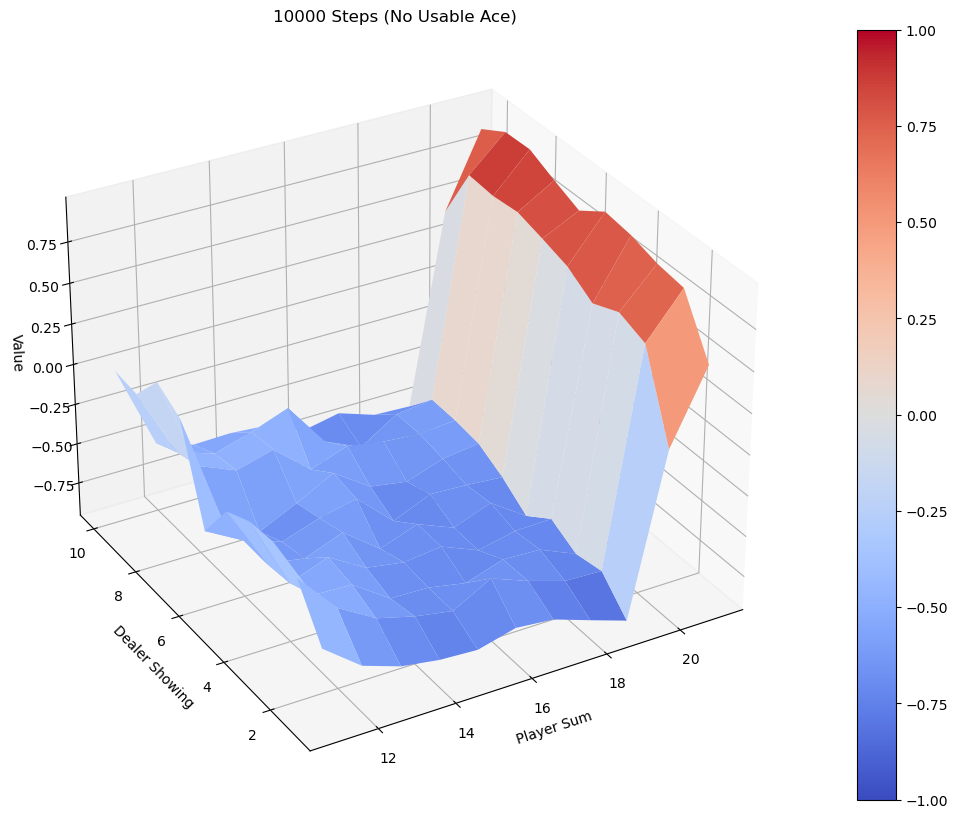

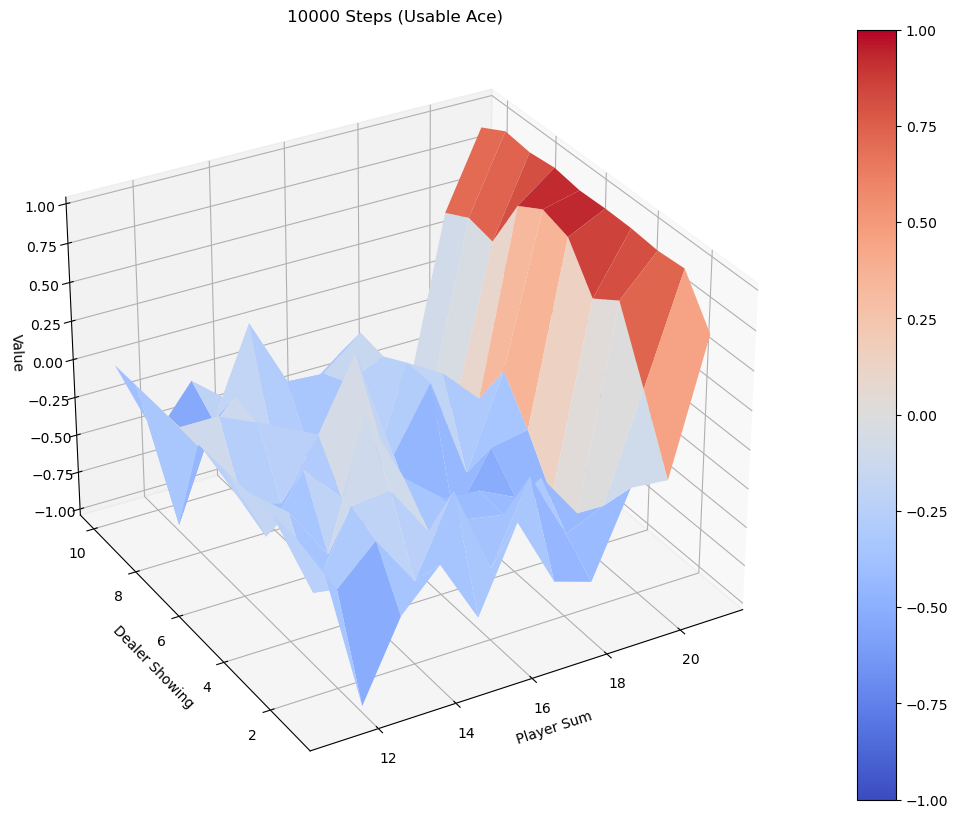

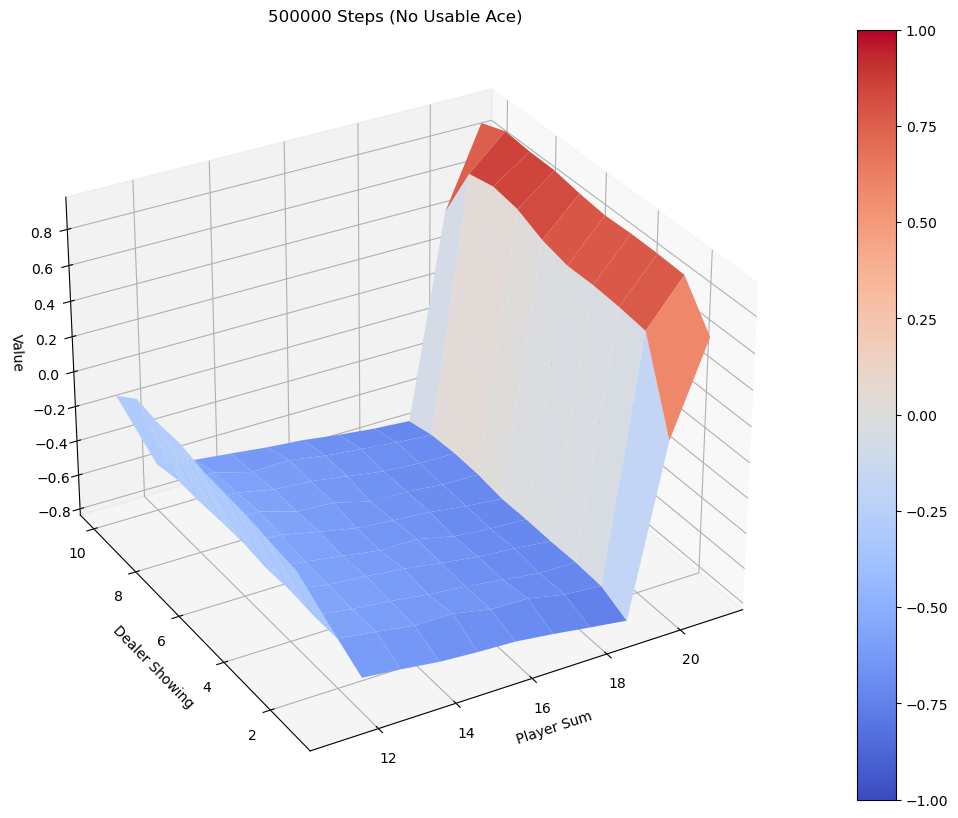

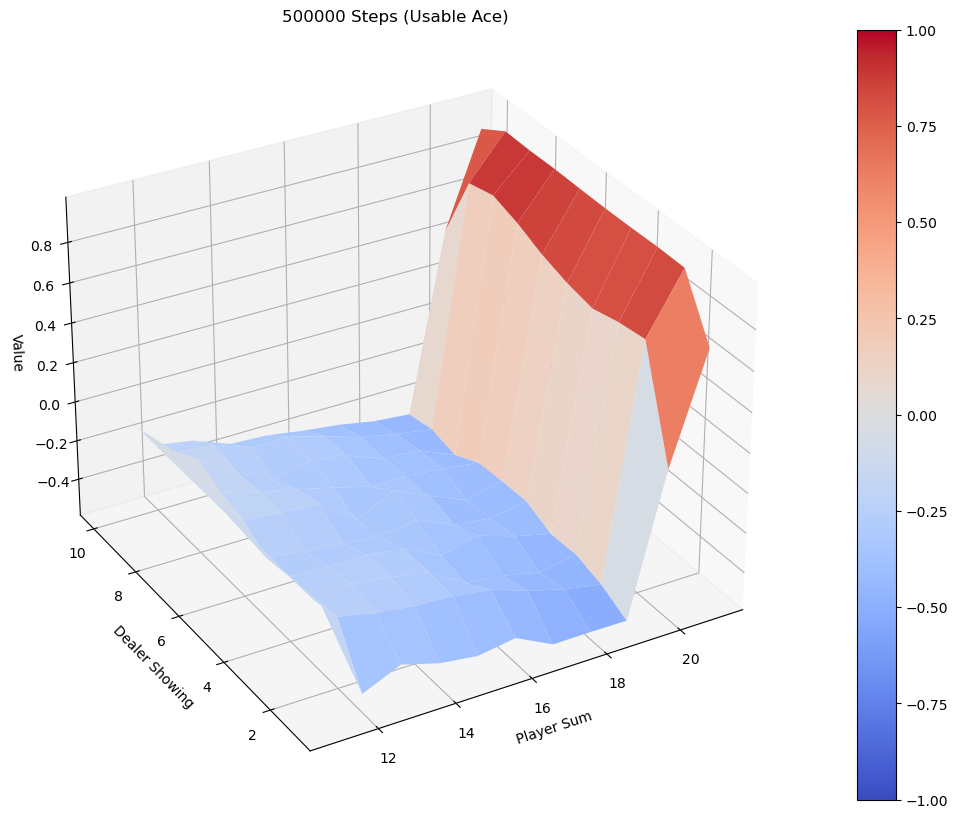

In [45]:
V_10k = mc_prediction(sample_policy, env, num_episodes = 10000)
plot_value_function(V_10k, title = '10000 Steps' )

V_500k = mc_prediction(sample_policy, env, num_episodes = 500000)
plot_value_function(V_500k, title = '500000 Steps')

In [28]:


def make_epsilon_greedy_policy(Q, epsilon, nA):
    '''
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    '''
    def policy_fn(observation):
        # Implement this!
        props = np.ones(nA, dtype = float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        props[best_action] += 1. - epsilon
        return props
        
    return policy_fn



In [29]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor = 1.0, epsilon = 0.1):
    '''
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    '''
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for i_episode in range(num_episodes):
        observation = env.reset()
        
        episodes = []
        for i in range(100):
            props = policy(observation)
            action = np.random.choice(np.arange(len(props)), p = props)
            next_observation, reward, done, _ = env.step(action)
            episodes.append((observation, action, reward))
            
            if done:
                break
            observation = next_observation
        
        # find the unique observation
        pairs = set([(episode[0], episode[1]) for episode in episodes])
        for (observation, action) in pairs:
            pair = (observation, action)
            # find the first occurence of the observation
            idx = episodes.index([episode for episode in episodes if episode[0] == observation and episode[1] == action][0])
            V = sum([reward[2] * discount_factor ** i for i, reward in enumerate(episodes[idx:])])
            
            returns_sum[pair] += V
            returns_count[pair] += 1.
            
            Q[observation][action] = returns_sum[pair] / returns_count[pair]
    
    return Q, policy

In [30]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes = 500000, epsilon = 0.1)

# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title = 'Optimal Value Function')

TypeError: unhashable type: 'dict'